<a href="https://colab.research.google.com/github/phamngochieu123456/HK_Race/blob/master/HK_Race_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [100]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import softmax
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

# Process runs.csv

In [101]:
runs_df = pd.read_csv(r"/content/runs.csv", delimiter=",", header=0)
runs_df = runs_df[['race_id', 'draw', 'horse_age', 'horse_country', 'horse_type',
                   'horse_rating', 'declared_weight', 'actual_weight', 'win_odds',
                   'place_odds', 'result']]

In [102]:
runs_df['declared_weight - actual_weight'] = runs_df['declared_weight'] - runs_df['actual_weight']

In [103]:
runs_df.describe()

,race_id,draw,horse_age,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result,declared_weight - actual_weight
count,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,79447.000000,75712.000000,79447.000000,79447.000000
mean,3173.352814,6.876005,3.339346,61.034904,1104.953568,122.729656,28.812977,7.423177,6.838597,982.223912
std,1833.101494,3.747589,0.876763,11.748788,62.347597,6.305496,30.097375,8.823430,3.730498,62.402631
min,0.000000,1.000000,2.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,571.000000
25%,1586.000000,4.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000,939.000000
50%,3174.000000,7.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000,979.000000
75%,4764.500000,10.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.600000,10.000000,1023.000000
max,6348.000000,15.000000,10.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000,1240.000000


In [104]:
np.unique(runs_df['horse_country'][runs_df['horse_country'].notnull()])

array(['ARG', 'AUS', 'BRZ', 'CAN', 'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY',
       'JPN', 'NZ', 'SAF', 'SPA', 'USA', 'ZIM'], dtype=object)

In [105]:
np.unique(runs_df['horse_type'][runs_df['horse_type'].notnull()])

array(['Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'], dtype=object)

In [106]:
np.where(runs_df.isnull())

(array([  182,   182,   846, ..., 79444, 79445, 79446]),
 array([3, 4, 3, ..., 9, 9, 9]))

In [107]:
drop_index = runs_df[runs_df['race_id'] == 5188].index
runs_df = runs_df.drop(drop_index)

horse_country_encoder = preprocessing.LabelEncoder()
runs_df['horse_country'] = pd.Series(horse_country_encoder.fit_transform(
    runs_df['horse_country'][runs_df['horse_country'].notnull()]),
                                     index=runs_df['horse_country'][runs_df['horse_country'].notnull()].index)

horse_type_encoder = preprocessing.LabelEncoder()
runs_df['horse_type'] = pd.Series(horse_type_encoder.fit_transform(
    runs_df['horse_type'][runs_df['horse_type'].notnull()]),
                                     index=runs_df['horse_type'][runs_df['horse_type'].notnull()].index)

imputer = KNNImputer(n_neighbors=20)
runs_df_numpy = imputer.fit_transform(runs_df)

runs_df = pd.DataFrame(data=runs_df_numpy, columns=runs_df.columns, index=runs_df.index)

In [108]:
horse_country_encoder.classes_

array(['ARG', 'AUS', 'BRZ', 'CAN', 'FR', 'GB', 'GER', 'GR', 'IRE', 'ITY',
       'JPN', 'NZ', 'SAF', 'SPA', 'USA', 'ZIM'], dtype=object)

In [109]:
horse_type_encoder.classes_

array(['Brown', 'Colt', 'Filly', 'Gelding', 'Grey', 'Horse', 'Mare',
       'Rig', 'Roan'], dtype=object)

In [110]:
runs_df.describe()

,race_id,draw,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,win_odds,place_odds,result,declared_weight - actual_weight
count,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000,79433.000000
mean,3172.997734,6.875845,3.339330,6.299149,2.962079,61.033664,1104.949934,122.729898,28.812755,7.381905,6.838480,982.220036
std,1833.067877,3.747446,0.876743,4.591245,0.611888,11.749231,62.347180,6.305385,30.096684,8.710660,3.730432,62.401647
min,0.000000,1.000000,2.000000,0.000000,0.000000,10.000000,693.000000,103.000000,1.000000,1.000000,1.000000,571.000000
25%,1585.000000,4.000000,3.000000,1.000000,3.000000,60.000000,1062.000000,118.000000,7.700000,2.400000,4.000000,939.000000
50%,3174.000000,7.000000,3.000000,8.000000,3.000000,60.000000,1102.000000,123.000000,15.000000,4.100000,7.000000,979.000000
75%,4764.000000,10.000000,3.000000,11.000000,3.000000,60.000000,1146.000000,128.000000,38.000000,8.500000,10.000000,1023.000000
max,6348.000000,14.000000,10.000000,15.000000,8.000000,138.000000,1369.000000,133.000000,99.000000,101.000000,14.000000,1240.000000


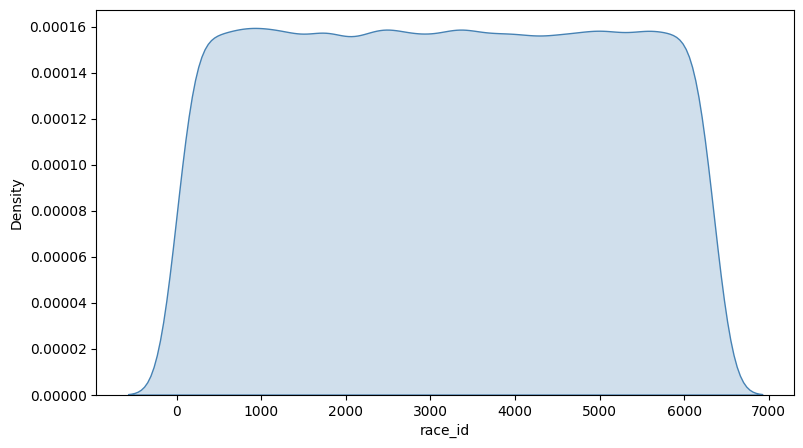

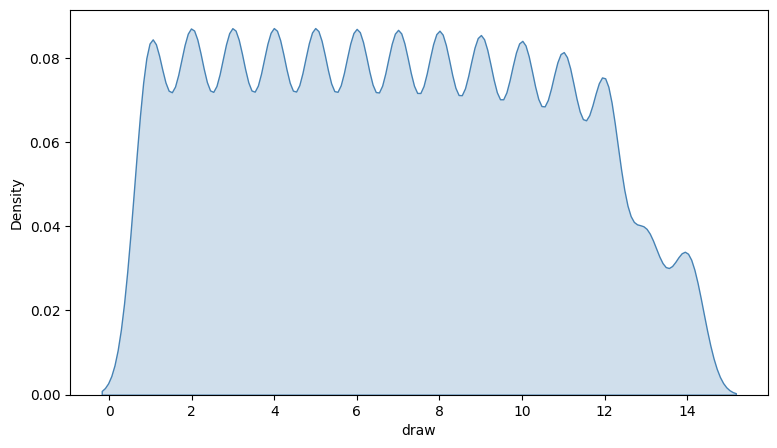

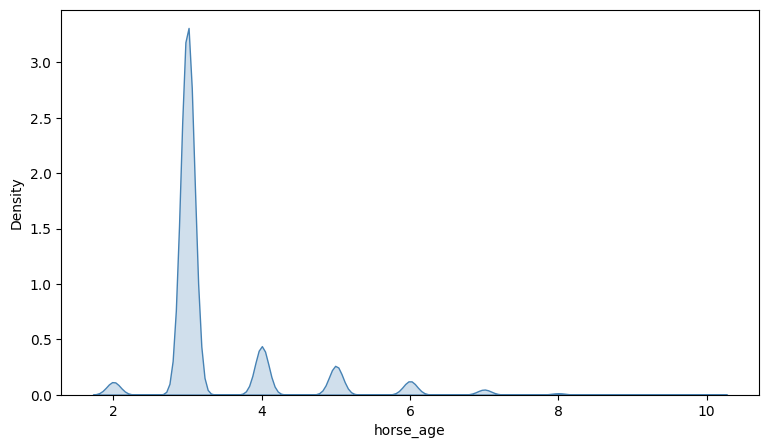

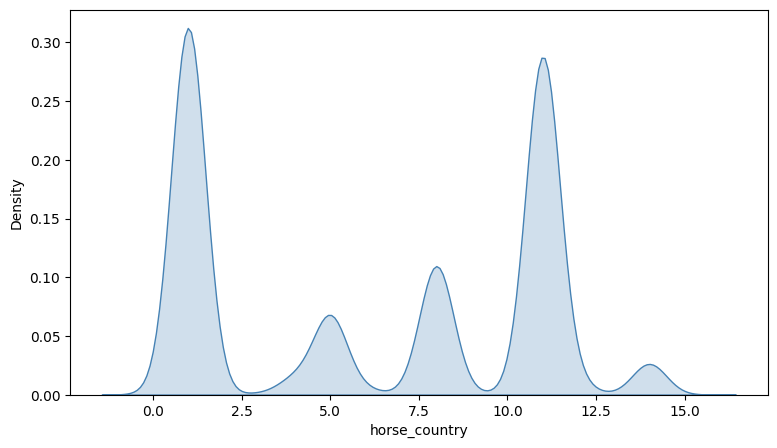

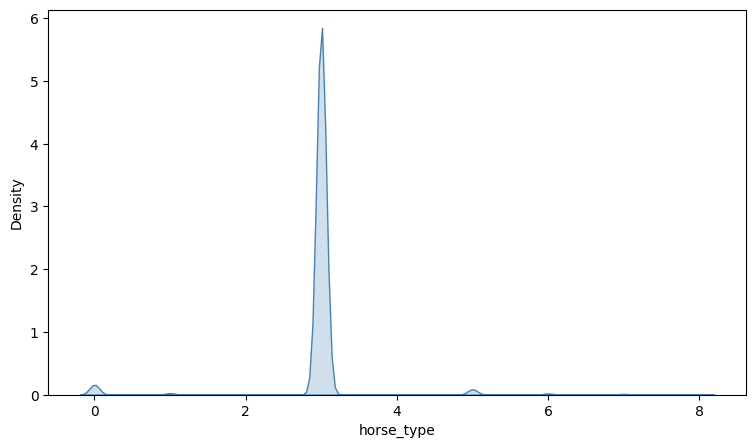

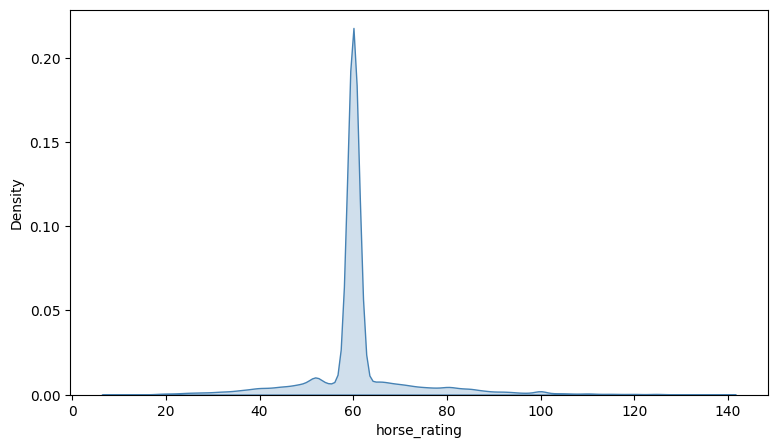

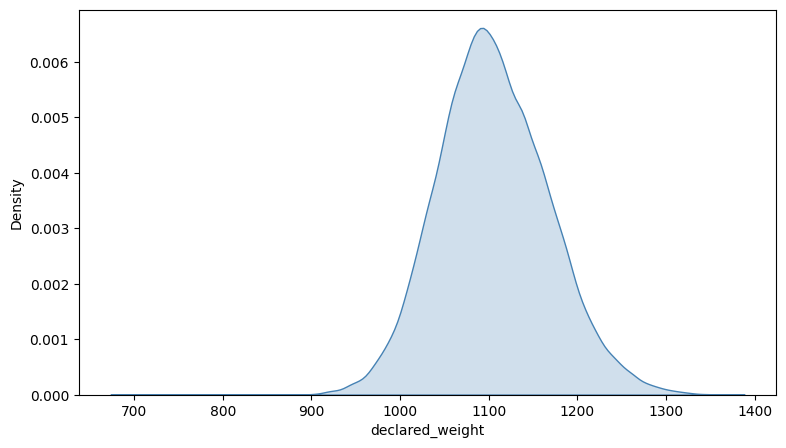

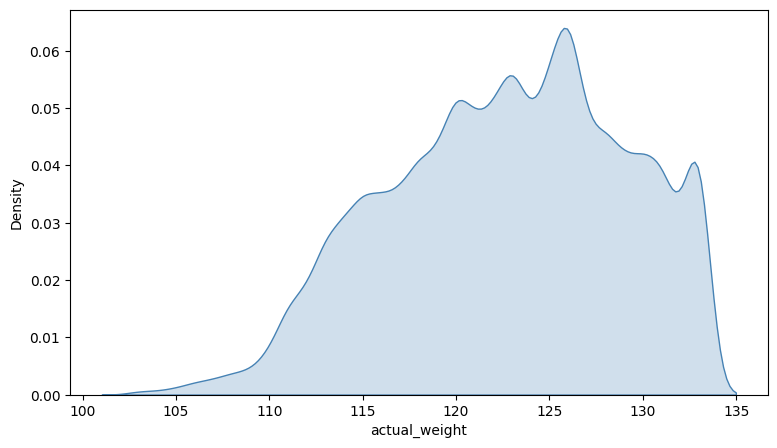

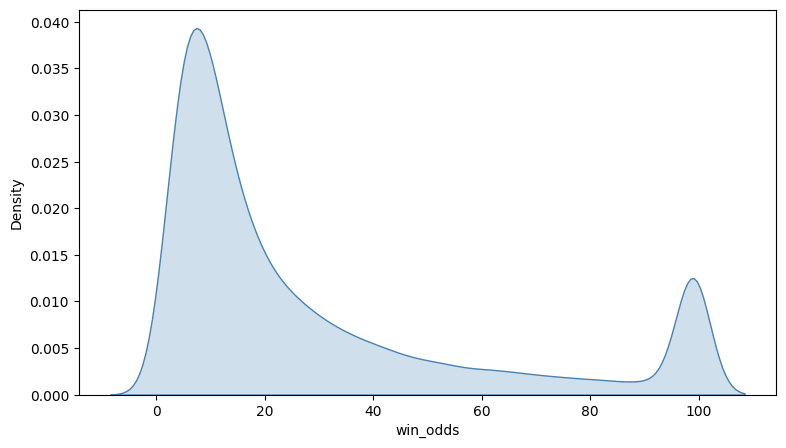

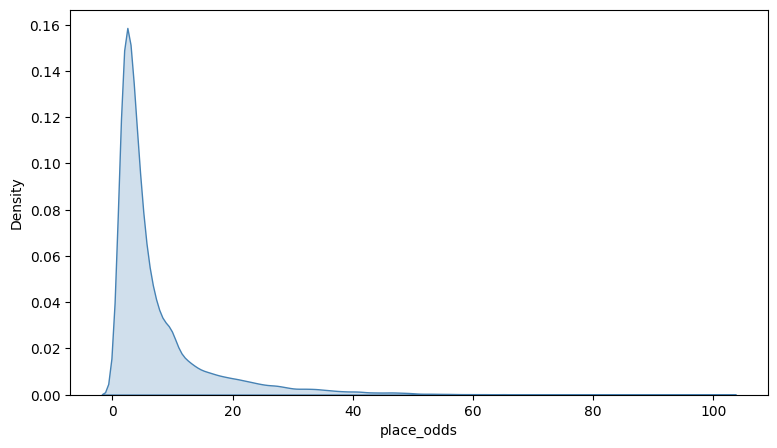

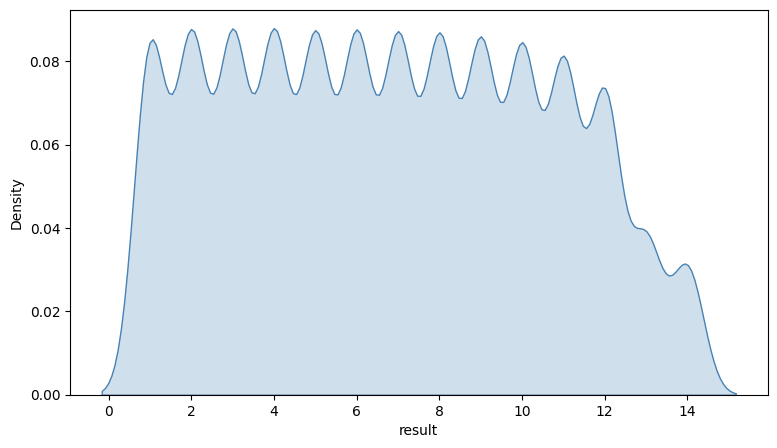

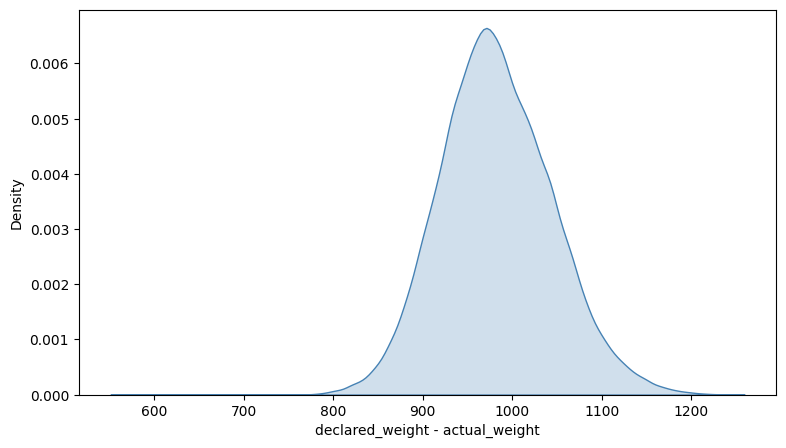

In [111]:
run_column_len = len(runs_df.columns)

for i in range(run_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=runs_df[runs_df.columns[i]], fill=True, color='steelblue')

# Process races.csv

In [112]:
races_df = pd.read_csv(r"/content/races.csv", delimiter=",", header=0)
races_df = races_df[['race_id', 'venue', 'config', 'surface', 'distance', 'going', 'race_class']]

In [113]:
races_df.describe()

,race_id,surface,distance,race_class
count,6349.000000,6349.000000,6349.000000,6349.000000
mean,3174.000000,0.109151,1419.113246,3.893684
std,1832.942761,0.311853,281.468745,1.992868
min,0.000000,0.000000,1000.000000,0.000000
25%,1587.000000,0.000000,1200.000000,3.000000
50%,3174.000000,0.000000,1400.000000,4.000000
75%,4761.000000,0.000000,1650.000000,4.000000
max,6348.000000,1.000000,2400.000000,13.000000


In [114]:
np.where(races_df.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [115]:
np.unique(races_df['venue'])

array(['HV', 'ST'], dtype=object)

In [116]:
np.unique(races_df['config'])

array(['A', 'A+3', 'B', 'B+2', 'C', 'C+3'], dtype=object)

In [117]:
np.unique(races_df['going'])

array(['FAST', 'GOOD', 'GOOD TO FIRM', 'GOOD TO YIELDING', 'SLOW', 'SOFT',
       'WET FAST', 'WET SLOW', 'YIELDING', 'YIELDING TO SOFT'],
      dtype=object)

In [118]:
config_encoder = preprocessing.OrdinalEncoder()
races_df['config'] = config_encoder.fit_transform(races_df['config'].values.reshape(-1, 1))
going_encoder = preprocessing.OrdinalEncoder()
races_df['going'] = going_encoder.fit_transform(races_df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
races_df['venue'] = venue_encoder.fit_transform(races_df['venue'])

In [119]:
config_encoder.categories_

[array(['A', 'A+3', 'B', 'B+2', 'C', 'C+3'], dtype=object)]

In [120]:
going_encoder.categories_

[array(['FAST', 'GOOD', 'GOOD TO FIRM', 'GOOD TO YIELDING', 'SLOW', 'SOFT',
        'WET FAST', 'WET SLOW', 'YIELDING', 'YIELDING TO SOFT'],
       dtype=object)]

In [121]:
venue_encoder.classes_

array(['HV', 'ST'], dtype=object)

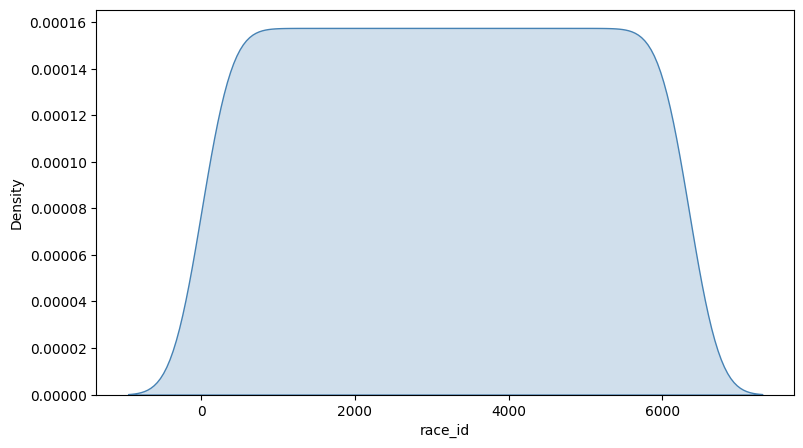

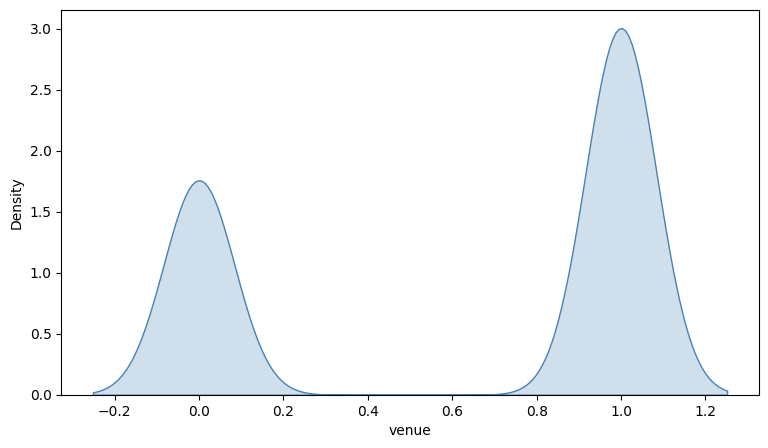

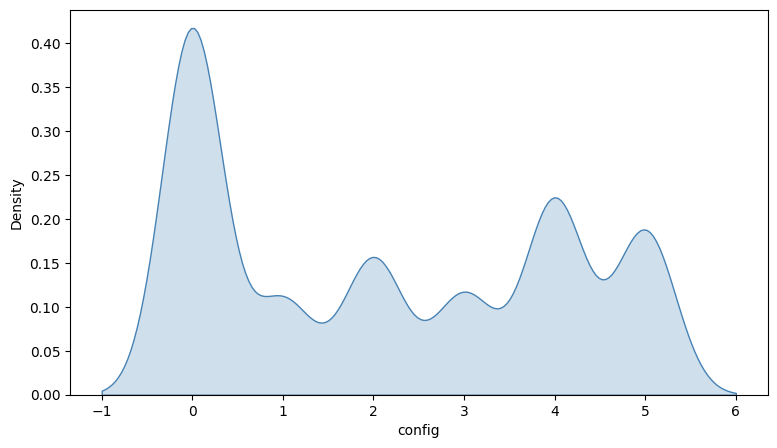

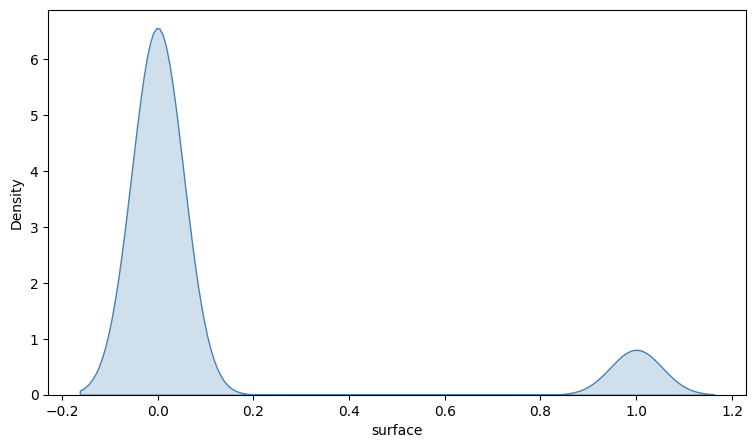

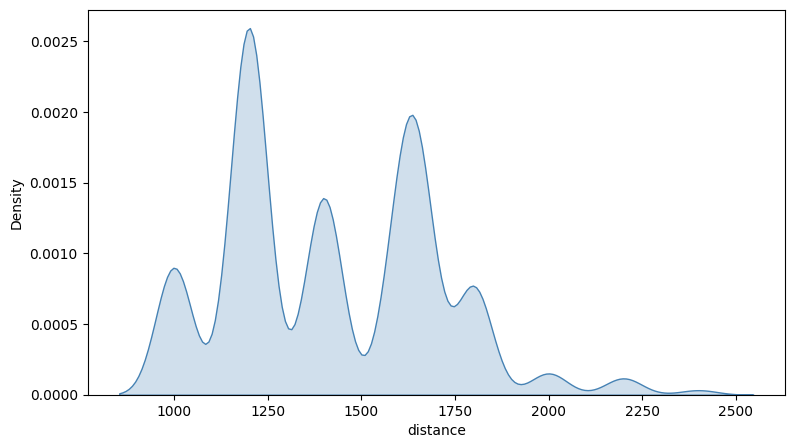

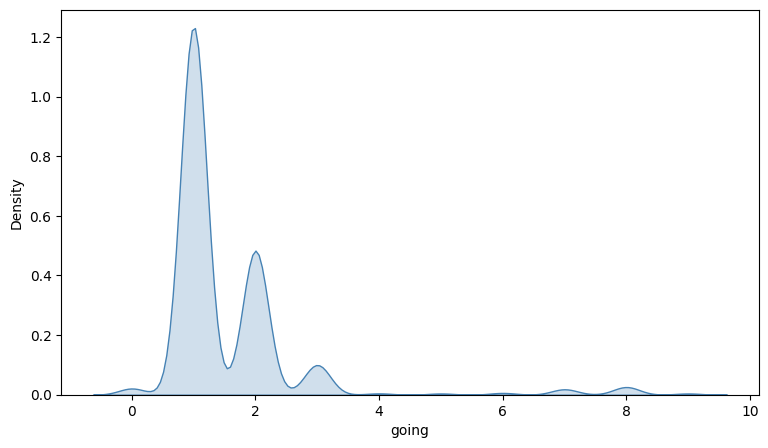

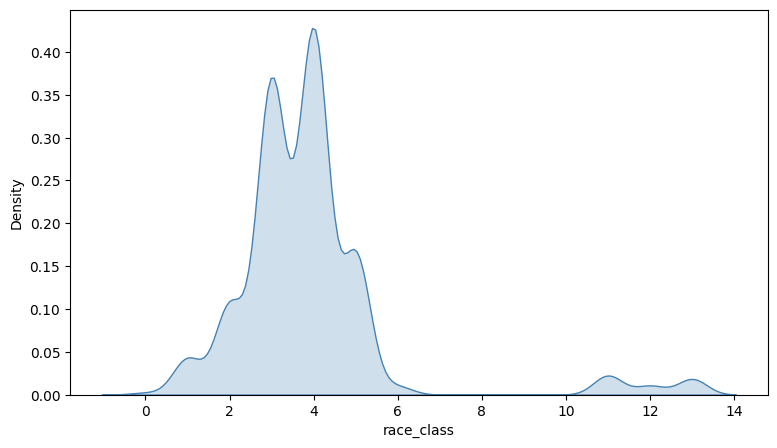

In [122]:
race_column_len = len(races_df.columns)

for i in range(race_column_len):
  plt.figure(figsize=(9, 5))
  sns.kdeplot(data=races_df[races_df.columns[i]], fill=True, color='steelblue')

# Combine dataset

In [123]:
data = runs_df.merge(races_df, how='inner', on='race_id')

In [124]:
np.where(data.isnull())

(array([], dtype=int64), array([], dtype=int64))

<Axes: >

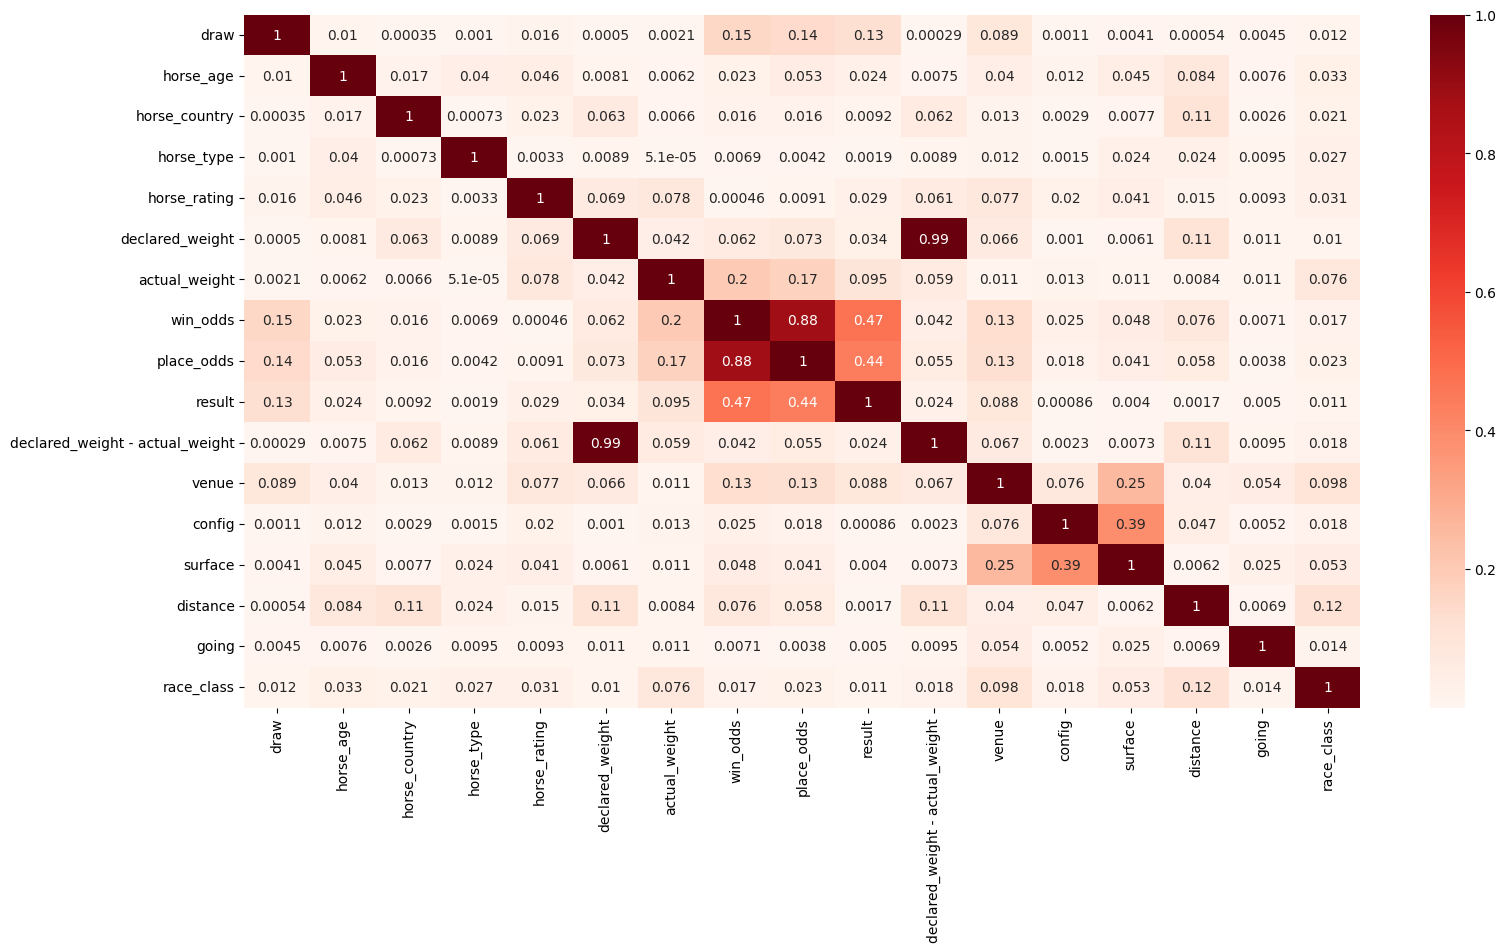

In [125]:
plt.figure(figsize=(18,9))
sns.heatmap(abs(data.drop('race_id',axis=1).corr()),cmap = "Reds", annot=True,)

# Ranking

In [142]:
use_column = ['race_id', 'result', 'draw']
use_column_pre = ['result', 'draw']

In [143]:
gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 42).split(data, groups=data['race_id'])

X_train_inds, X_test_inds = next(gss)

train_data= data.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(use_column)]
y_train = train_data.loc[:, train_data.columns.isin(['result'])]

groups = train_data.groupby('race_id').size().to_frame('size')['size'].to_numpy()

test_data= data.iloc[X_test_inds]

X_test = test_data.loc[:, ~test_data.columns.isin(use_column)]
y_test = test_data.loc[:, test_data.columns.isin(['result'])]

In [144]:
X_train

,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,win_odds,place_odds,declared_weight - actual_weight,venue,config,surface,distance,going,race_class
0,3.0,1.0,3.0,60.0,1020.0,133.0,9.7,3.700,887.0,1,0.0,0,1400,2.0,5
1,3.0,11.0,3.0,60.0,980.0,133.0,16.0,4.900,847.0,1,0.0,0,1400,2.0,5
2,3.0,11.0,3.0,60.0,1082.0,132.0,3.5,1.500,950.0,1,0.0,0,1400,2.0,5
3,3.0,12.0,3.0,60.0,1118.0,127.0,39.0,11.000,991.0,1,0.0,0,1400,2.0,5
4,3.0,5.0,3.0,60.0,972.0,131.0,50.0,14.000,841.0,1,0.0,0,1400,2.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79428,5.0,1.0,3.0,87.0,1191.0,122.0,99.0,15.695,1069.0,1,0.0,0,1600,1.0,2
79429,5.0,11.0,3.0,84.0,1070.0,119.0,99.0,18.005,951.0,1,0.0,0,1600,1.0,2
79430,5.0,11.0,3.0,83.0,1148.0,120.0,99.0,18.150,1028.0,1,0.0,0,1600,1.0,2
79431,3.0,1.0,3.0,82.0,1266.0,119.0,4.6,5.290,1147.0,1,0.0,0,1600,1.0,2


In [145]:
model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.8,
    eta=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.75
    )

model.fit(X_train, y_train,
          group=groups,
          verbose=True,
          feature_weights=[1, 1, 1, 1, 1, 1, 0.5, 0.5, 1, 1, 1, 1, 1, 1, 1])

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.8,
          early_stopping_rounds=None, enable_categorical=False, eta=0.05,
          eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, n_estimators=200, n_jobs=None,
          num_parallel_tree=None, predictor=None, ...)

In [146]:
def predict(model, df):
    array = model.predict(df.loc[:, ~df.columns.isin(['race_id'])])
    return array.argsort().argsort() + 1

In [147]:
predictions_train = (
    train_data.loc[:, ~train_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_train = train_data.loc[:, train_data.columns.isin(['race_id', 'result'])]
y_true_train = y_true_train.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

predictions_test = (
    test_data.loc[:, ~test_data.columns.isin(use_column_pre)]
    .groupby('race_id').apply(lambda x: predict(model, x)))

y_true_test = test_data.loc[:, test_data.columns.isin(['race_id', 'result'])]
y_true_test = y_true_test.groupby('race_id').apply(lambda x: x['result'].to_numpy(dtype=int))

In [148]:
def calculate_top3_error(y_true, predictions):
    correct_idxs = []
    wrong_idxs = []
    total_races = len(y_true)
    correct_predictions = 0

    for race_id, true_positions in y_true.items():
        true_pos = np.where(true_positions == 1)[0][0]
        top3_pred = predictions[race_id].argsort()[:3]
        if true_pos in top3_pred:
            correct_predictions += 1
            correct_idxs.append(race_id)
        else:
            wrong_idxs.append(race_id)

    top3_error = correct_predictions / total_races
    return top3_error, correct_idxs, wrong_idxs

In [149]:
top3_error_train, correct_idxs_train, wrong_idxs_train = calculate_top3_error(y_true_train, predictions_train)
top3_error_test, correct_idxs_test, wrong_idxs_test = calculate_top3_error(y_true_test, predictions_test)
print(f"Top-3 Error Train: {top3_error_train:.4f}")
print(f"Top-3 Error Test: {top3_error_test:.4f}")

Top-3 Error Train: 0.6189
Top-3 Error Test: 0.6087


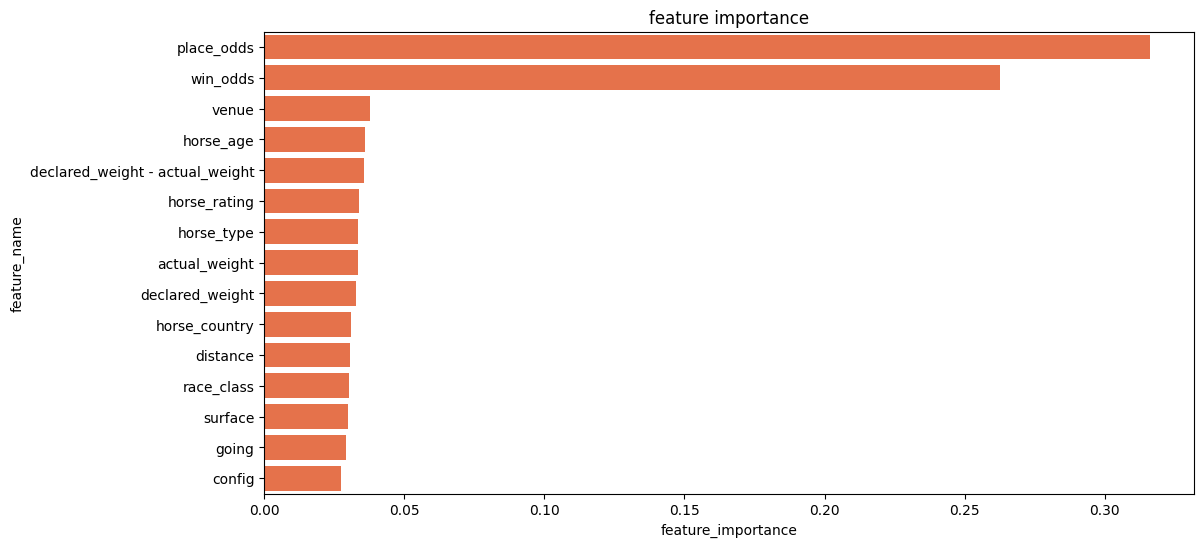

In [150]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

In [151]:
true_idxs = np.random.choice(len(correct_idxs_test), 3, replace=False)
false_idxs = np.random.choice(len(wrong_idxs_test), 3, replace=False)

correct_idxs_test = np.array(correct_idxs_test)
wrong_idxs_test = np.array(wrong_idxs_test)

In [152]:
y_true_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
422.0             [10, 6, 5, 12, 9, 11, 8, 1, 2, 4, 7, 3]
2618.0            [4, 8, 6, 9, 7, 3, 2, 11, 5, 1, 12, 10]
3357.0    [10, 7, 9, 6, 11, 4, 12, 1, 5, 8, 3, 2, 13, 14]
dtype: object

In [153]:
predictions_test.iloc[np.where(predictions_test.index.isin(correct_idxs_test[true_idxs]) == True)[0]]

race_id
422.0             [7, 8, 3, 6, 9, 12, 10, 1, 11, 2, 5, 4]
2618.0            [10, 7, 6, 5, 4, 9, 2, 11, 8, 1, 3, 12]
3357.0    [4, 6, 11, 10, 9, 3, 13, 2, 8, 7, 5, 1, 14, 12]
dtype: object

In [154]:
data.iloc[np.where(data['race_id'].isin(correct_idxs_test[true_idxs]) == True)[0]][['race_id', 'win_odds', 'place_odds', 'result']]

,race_id,win_odds,place_odds,result
5255,422.0,17.0,4.2,10.0
5256,422.0,18.0,4.6,6.0
5257,422.0,5.7,2.0,5.0
5258,422.0,16.0,3.5,12.0
5259,422.0,24.0,5.0,9.0
5260,422.0,52.0,13.0,11.0
5261,422.0,30.0,7.9,8.0
5262,422.0,2.5,1.3,1.0
5263,422.0,37.0,8.8,2.0
5264,422.0,5.9,2.1,4.0


In [155]:
y_true_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
2552.0                   [4, 5, 2, 1, 8, 3, 7, 6]
3221.0    [7, 4, 1, 10, 12, 11, 3, 8, 6, 5, 9, 2]
4322.0    [12, 5, 1, 3, 4, 10, 7, 6, 11, 9, 2, 8]
dtype: object

In [156]:
predictions_test.iloc[np.where(predictions_test.index.isin(wrong_idxs_test[false_idxs]) == True)[0]]

race_id
2552.0                   [1, 7, 3, 8, 6, 4, 5, 2]
3221.0    [2, 3, 5, 8, 6, 12, 1, 9, 10, 11, 7, 4]
4322.0    [4, 7, 8, 5, 6, 10, 11, 2, 12, 1, 3, 9]
dtype: object

In [157]:
data.iloc[np.where(data['race_id'].isin(wrong_idxs_test[false_idxs]) == True)[0]][['race_id', 'win_odds', 'place_odds', 'result']]

,race_id,win_odds,place_odds,result
31960,2552.0,1.5,1.1,4.0
31961,2552.0,30.0,3.6,5.0
31962,2552.0,10.0,1.8,2.0
31963,2552.0,42.0,6.5,1.0
31964,2552.0,21.0,3.6,8.0
31965,2552.0,14.0,2.1,3.0
31966,2552.0,19.0,3.5,7.0
31967,2552.0,4.0,1.3,6.0
40302,3221.0,4.5,1.7,7.0
40303,3221.0,4.7,1.8,4.0
